<hr>

# Program plots profiles of state variables and process tendencies at various locations and times of ENSO phase

<ul>
<li> Level 1: Mean profiles of states and tendencies during ENSO phase (seasons: monthly means) </li>
<li> Level 2: Time varying profiles during a season or seasonal transtion </li>
<li> Level 3: Statistical reltiosnhips between vertical processes and ENSO/forcing/dynamical strength </li>
</ul>
<hr>

In [12]:

import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt

import cartopy.crs as ccrs
import pandas as pd
import metpy as mpy
import dask as ds

In [13]:
### To Import My Functions ###
import vert_proc_func as mypy
import importlib


# Initial Simulation Information

In [41]:
importlib.reload(mypy) # Required because I am constantly editing scam_func.py

''''' Which phase of enso to work with and the nino SST region '''''
enso_phase = 'nino34'



''''' Which case to use '''''

#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'
#case_desc = np.array(['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc','rZMp','rpfrac','rTMS','rGW']) ; pref_out = 'revert'                      
#case_desc = np.array(['C6','rC5']) ; pref_out = 'test'     
#case_type = np.array(['cam','cam'])

case_desc = np.array(['ERA5']) ; pref_out = 'ERA5_test'     
case_type = np.array(['reanal'])


''''' Season to examine '''''

#month_ave = np.array(["Jul","Aug","Sep","Oct","Nov"]) 
month_ave = np.array(["Jan","Feb","Dec"])


clim_anal = False

''''' Years for the analysis '''''

years_data = [1979,1990] # Year range of history files to read.



''''' Directory Information '''''

dir_croot = '/glade/p/cgd/amp/people/hannay/amwg/climo/' # Directories with climo files
dir_hroot = '/glade/p/cgd/amp/amwg/runs/' # Run firectories with history files

dir_proot = '/glade/u/home/rneale/python/python-figs/vert_proc/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'







''''' Variable description '''''

var_cam = 'T'





## Variables ##

var_desc = {}

var_desc['DTCOND'] = ['dT/dt Total',86400.,1., -5.,5.,'K/day']
var_desc['DCQ']    = ['dq/dt Total',86400*1000.,1., -4.,4.,'g/kg/day']
var_desc['ZMDT']   = ['dT/dt Convection',86400., 1.,-5.,5.,'K/day']
var_desc['ZMDQ']   = ['dq/dt Convection',86400.*1000., 1.,-4.,4.,'g/kg/day']
var_desc['STEND_CLUBB'] = ['dT/dt turbulence',86400./1004., 1. ,-2.,8.,'K/day']
var_desc['OMEGA'] = ['OMEGA',-1., -100./86400., -0.06,0.06,'pa/s']
var_desc['DIV'] = ['Divergence',1., 100./86400., -0.0005,0.0005,'/s']
var_desc['T'] = ['Temperature',1., 1., -10.,10.,'K']

''''' Named Regions '''''

reg_names = {}

reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,210]  # Core of nino precip signal
reg_names['WP Dry']   = ['West Pac. Nino Dry.',-5,10.,120.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,50.,160,190]       # Core of RWS convergence min.



# Include observations? #
lobs = True

# Pressure info.
ppmin = 50. ; ppmax = 1000.
p_levs = np.arange(ppmin,ppmax,50.)



###### NAMES CATALOGUE ######
#sim_names = cam_revert_list()
#sim_names = cam_vres_list()
sim_names = mypy.cam_reanal_list()




## Specify data frames ##

reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])
var_df = pd.DataFrame.from_dict(var_desc, orient='index',columns=['long_name','vscale','ovscale','xmin','xmax','vunits'])

display(reg_df)
print()
display(var_df)

,long_name,lat_s,lat_n,lon_w,lon_e
Nino Wet,C. Pacific Nino Wet,-10,0.0,160.0,210
WP Dry,West Pac. Nino Dry.,-5,10.0,120.0,150


,long_name,vscale,ovscale,xmin,xmax,vunits
DTCOND,dT/dt Total,8.640000e+04,1.000000,-5.0000,5.0000,K/day
DCQ,dq/dt Total,8.640000e+07,1.000000,-4.0000,4.0000,g/kg/day
ZMDT,dT/dt Convection,8.640000e+04,1.000000,-5.0000,5.0000,K/day
ZMDQ,dq/dt Convection,8.640000e+07,1.000000,-4.0000,4.0000,g/kg/day
STEND_CLUBB,dT/dt turbulence,8.605578e+01,1.000000,-2.0000,8.0000,K/day
OMEGA,OMEGA,-1.000000e+00,-0.001157,-0.0600,0.0600,pa/s
DIV,Divergence,1.000000e+00,0.001157,-0.0005,0.0005,/s
T,Temperature,1.000000e+00,1.000000,-10.0000,10.0000,K


# Main Code
## Monthly Climatologies

-Averaging for months -  ['Jan' 'Feb' 'Dec']



**** CASE #  [1]  OF  1  ****
- Name =  ERA5  -> ERA5


FileNotFoundError: [Errno 2] No such file or directory: b'/glade/p/cgd/amp/people/hannay/amwg/climo/ERA5/0.9x1.25/ERA5_01_climo.nc'

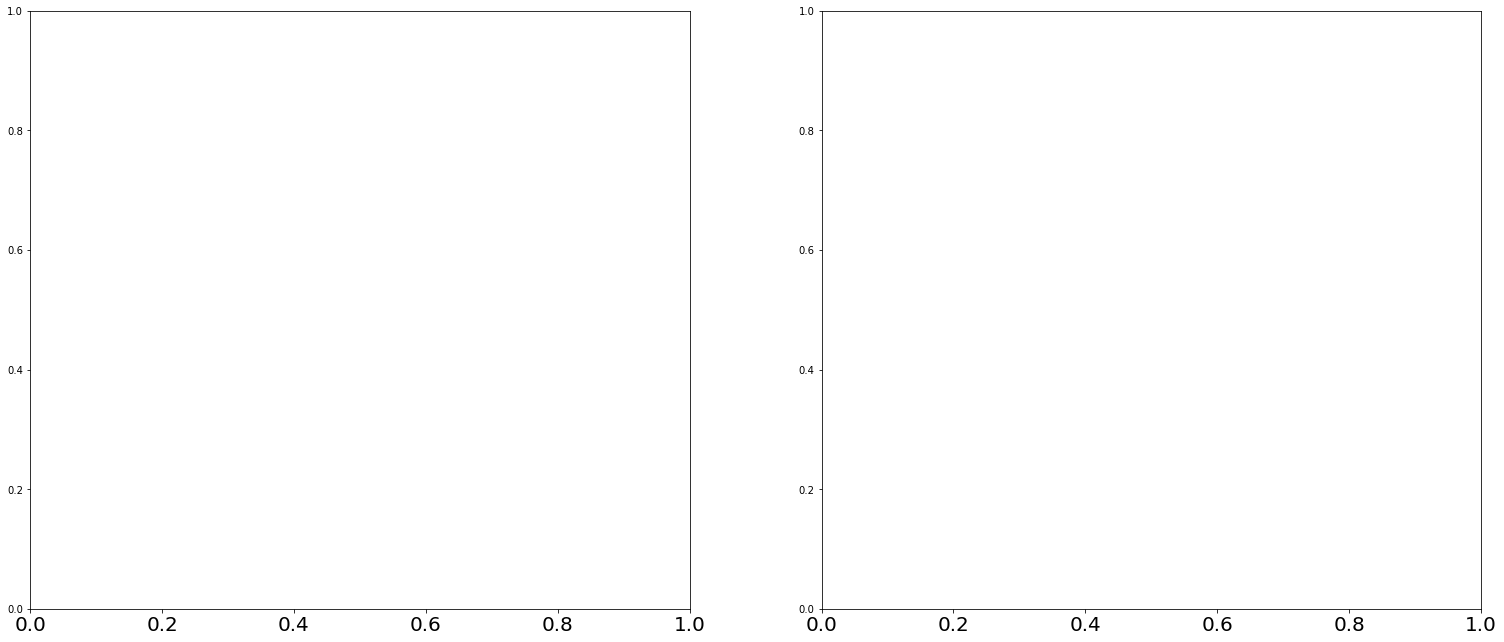

In [42]:
# Plan #

# - Seasonal Means - 
# - Cases -
# - Variables -
# 1. - Tendency Fields -
# 1. - Global fields -
# 1. - Global, vertical intergrals -
# 2. - Global PDFs (p levels)
# 3. - ENSO differences
# 3. - Dynamic Criteria (W500,PRECT)



nmnths = month_ave.size
ncases = case_desc.size
nregions = reg_df.index.size

xmin = var_df.loc[var_cam]['xmin'] ; xmax=var_df.loc[var_cam]['xmax']
vunits = var_df.loc[var_cam]['vunits'] 
var_text = var_df.loc[var_cam]['long_name']   


## LOOP ##
fig, ax = mp.subplots(1,nregions,figsize=(26, 11))



print('-Averaging for months - ',month_ave)
print('')

#### Month numbering/concatonation ###
mnums = []

# Construct month strings
for im in range(0,nmnths): mnums.append(dt.datetime.strptime(month_ave[im], "%b").month)
mon_aves = [ "{:02}".format(x) for x in mnums ] # In correct format
mon_list = ','.join(mon_aves)


#####################
## Get CAM variable
#####################


# USe Observations ?? #

obs_vars = ['OMEGA','DIV']

lobs = True if np.any(np.isin(obs_vars,var_cam)) else False

if lobs: 
    obs_name = 'ERAI'
    ofiles_in = [dir_obs+obs_name+'_'+mon_aves[ff]+'_climo.nc' for ff in range(nmnths)]
    ofiles_ptr = xr.open_mfdataset(ofiles_in,parallel=True)
   
    if var_cam == 'DIV':         
        ovar_in = -ofiles_ptr['OMEGA'].mean(dim=['time']).differentiate("lev")  
    else :
        ovar_in = ofiles_ptr[var_cam].mean(dim=['time'])
    
    
    levs_o = ofiles_ptr['lev']
    ilevs_o = np.where(levs_o >= min(p_levs))
    ilevs_o = ilevs_o[0]



    
    
    
'''########################'''
'''##### LOOP CASES  ######'''
'''########################'''

for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times
    
# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
    
    print('')
    print('')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('- Name = ',case,' ->',sim_name)
                    
## Read data in from files ##

# Changes pref. depending on case
    pre_dir = 'yrs_1979-2005' if case=='CE2' else '0.9x1.25'  

# Detemine files for input
    cfiles_in = [dir_croot+sim_name+'/'+pre_dir+'/'+sim_name+'_'+mon_aves[ff]+'_climo.nc' for ff in range(nmnths)]
    
# Point to files
    cfiles_ptr = xr.open_mfdataset(cfiles_in)
       
# Region independent fields 
    hyam = cfiles_ptr['hyam'] ; hybm = cfiles_ptr['hybm'] ; P0 = cfiles_ptr['P0'] ; lev = cfiles_ptr['lev']
    ilevs = np.where(lev >= min(p_levs))
    ilevs = ilevs[0]
    dp_lev = np.diff(lev)
    

# GRAB VARIABLE DATA #
    
    var_in,var_name = mypy.cam_tend_var_get(cfiles_ptr,var_cam)
               

# Determine climo,nino3.4 (el Nino/La Nina time points)

    
        
    ''' ########################  
        ### Now Loop Regions
        #### -Plot mean 
        #### -Plot El Nino 
        #### -Plot La Nina 
        #########################
    '''
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##

### Assign lat/lon region domain ###

        reg_name = reg_df.loc[reg]['long_name'] 
    
        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print('  - Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0E %.1f-%d\u00b0N' % (reg_w,reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dE_%.1f-%dN' % (reg_w,reg_e,reg_s,reg_n)  
         
        print('-Averaging for region - ',reg_a_str)

        
### Scale, trim and average ###

        var_plot = var_df.loc[var_name]['vscale']*var_in.loc[:,reg_s:reg_n,reg_w:reg_e]
        var_plot = var_plot.mean(dim=['lat','lon'])   #### NEED TO ADD GW WEIGHTING HERE ###     
      
### Do something different for CAM5/CAM6
        pmark = 'x' if case_desc[icase] in ['C6','rC5'] else '.'
        ax[ireg].plot(var_plot[ilevs],lev[ilevs],lw=3,markersize=9,marker=pmark)  
 
        ax[ireg].set_title(reg_name+' -- '+reg_a_str,fontsize=20)
        ax[ireg].set_xlim([xmin,xmax])
        ax[ireg].set_ylim([ppmax,ppmin])
        ax[ireg].set_ylabel('mb',fontsize=20) 
        ax[ireg].set_xlabel(vunits,fontsize=20)      
        ax[ireg].set_yticks(p_levs)

        ax[ireg].grid(linestyle='--')  
        ax[ireg].vlines(0., ppmax, ppmin, linestyle="dashed",lw=1, color='black')


      
        if icase==ncases-1 and lobs: # Add obs. at end of last case
            ovar_plot = var_df.loc[var_name]['ovscale']*ovar_in.loc[:,reg_s:reg_n,reg_w:reg_e]
            ovar_plot = ovar_plot.mean(dim=['lat','lon']) 

#            if var_name == 'DIV':  
#                ovar_plot = ovar_plot.differentiate("lev")
            ax[ireg].plot(ovar_plot[ilevs_o],levs_o[ilevs_o],lw=3,markersize=9,marker='o',color = 'black')   

    
leg_cases = np.append(case_desc,'MERRA') if lobs else case_desc

lloc = 'lower right' if var_name in ['ZMDQ','STEND_CLUBB'] else 'lower left'
ax[0].legend(leg_cases,fontsize=15,loc = lloc)
ax[0].text(xmin+0.02*(xmax-xmin), ppmin+50,var_text, ha='left',fontsize=28)

mp.rcParams['xtick.labelsize'] = 15 # GLobal set of xtick label size    




# Hard copy    
mp.savefig(dir_proot+pref_out+'_vprof_'+var_name+'_'+reg_a_out+'_'+month_ave[0]+'_to_'+month_ave[nmnths-1]+'.png', dpi=150)
#mp.show()

# ENSO Phase Compositing of Tendencies 
- Read in hist timeseries
- Calculate SST nino timeseries
- Composites based on season for vertical profiles
- Composites vertical profiles minus climo.



**** CASE #  [1]  OF  1  ****
- Name =  ERA5  -> ERA5

case =  ERA5
reanal files - type allowed
-Grabbing data type/case -- reanal ERA5
['/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1979/e5.moda.an.pl.128_130_t.ll025sc.1979010100_1979120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1980/e5.moda.an.pl.128_130_t.ll025sc.1980010100_1980120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1981/e5.moda.an.pl.128_130_t.ll025sc.1981010100_1981120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1982/e5.moda.an.pl.128_130_t.ll025sc.1982010100_1982120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1983/e5.moda.an.pl.128_130_t.ll025sc.1983010100_1983120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1984/e5.moda.an.pl.128_130_t.ll025sc.1984010100_1984120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1985/e5.moda.an.pl.128_130_t.ll025sc.1985010100_1985120100.nc'
 '/glade/collections/rda/data/ds633.1/e5.moda.an.pl/1986/

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'strftime' (time: 2064)>
array(['Jan', 'Feb', 'Mar', ..., 'Oct', 'Nov', 'Dec'], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2021-12-16 12:00:00
['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
<xarray.DataArray 'strftime' (time: 2064)>
array(['Jan', 'Feb', 'Mar', ..., 'Oct', 'Nov', 'Dec'], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2021-12-16 12:00:00
<xarray.DataArray 'strftime' (time: 2064)>
array(['1850', '1850', '1850', ..., '2021', '2021', '2021'], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2021-12-16 12:00:00
Apr
Aug
Dec
Feb
Jan
Jul
Jun
Mar
May
Nov
Oct
Sep
<xarray.DataArray 'time' (time: 2064)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
      

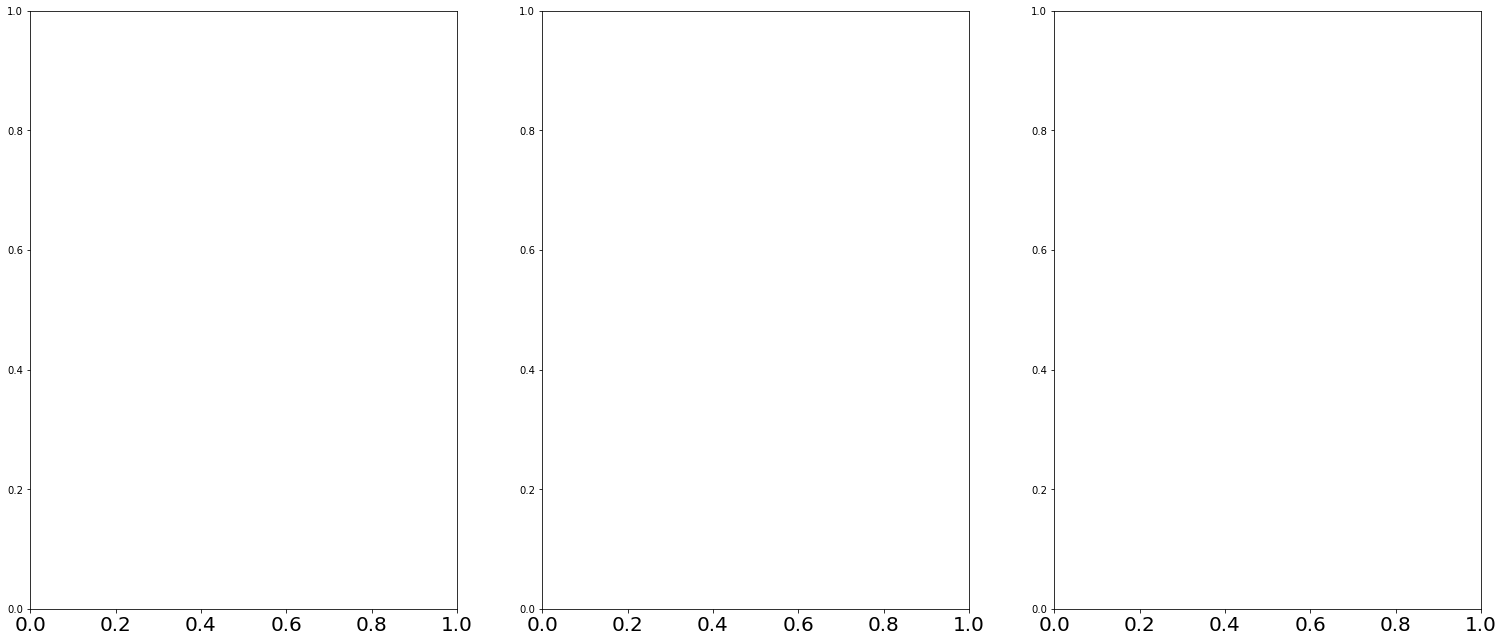

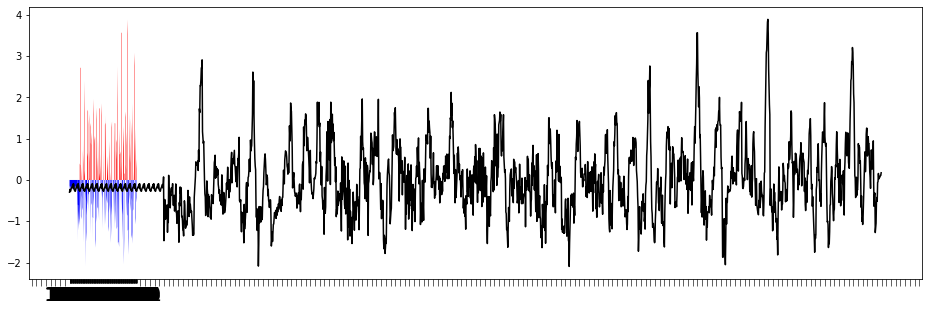

NameError: name 'nino_ts' is not defined

In [108]:



importlib.reload(mypy) # Required because I am constantly editing scam_func.py

### Read in history monthly mean files and composite profiles for tendencies###
dir_hroot = '/glade/p/cgd/amp/amwg/runs/'

#### Read in Data ####

yr0 = years_data[0]
yr1 = years_data[1]


nino_names = ['Climatology ('+str(yr0)+'-'+str(yr1)+')','El Nino','La Nina']

## LOOP ##
fign, axn = mp.subplots(1,3,figsize=(26, 11))










'''
########################
##### LOOP CASES  ######
########################
'''


for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
    
    print('')
    print('')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('- Name = ',case,' ->',sim_name)
                    
## Read data in from files ##

# Construct required history file month-year array

#    hist_myr = np.array([".cam.h0.%d-%02d.nc"%(y, m) for y in range(yr0,yr1+1) for m in range(1,12+1)])
#    num_h0 = hist_myr.size
  
    print('')
    print('case = ',case)
    
    
#    hfile_var = get_files_type(run_type,case_type,True) # Grab SST files
   
    files_ptr,var_name   = mypy.get_files_type(case,case_type[icase],var_cam,years_data) # Grab variable
    
## TS FROM HISTORY FILES (just copy for h0 files ##

    if case_type[icase] not in ['cam','cesm']:
       
        tfiles_ptr,tvar_name = mypy.get_files_type(case,case_type[icase],'TS',years_data) # Grab TS for nino timeseries
    else :
        tfiles_ptr = files_ptr ; tvar_name = 'TS'
#    if (case_type[icase]=='cam_local'):
    
# Determine files for input
#        hfiles_in = [dir_hroot+sim_name+'/atm/hist/'+sim_name+hist_myr[ff] for ff in range(num_h0)]
#        print(hfiles_in[0])
#        print(hfiles_in[-1])
    
# Point to files 
    # Point to files

# Have to modify based on month 1 is jan and not feb
#    hfiles_ptr.time.dt.month[0]=1





#    hmonths = hfiles_ptr.time.dt.month    

    ''' GET MONTHS FOR SST ANOMALIES '''
#    print(files_ptr.time)
    hmonths = files_ptr.time.dt.strftime("%b") 
  
    
    ''' SST ANOMALY ROUTINE ARRAY '''
  
    sst_data = tfiles_ptr[tvar_name]
    nino_ts,nina_ts = mypy.nino_sst_anom(case,sst_data,'nino3')
    
    
# Variable to plot.

# Seasons

    djf = ['Jan','Feb','Mar']

#    lmon_seas = np.where(hmonths in ['Jan','Feb','Mar']
   
    lmon_seas = np.isin(hmonths,djf)
    imon_seas = np.argwhere(lmon_seas)
    

# SST anoms and months

#    lnino_sst = nino_stats > np.std(nino_stats)
#    lnina_sst = nino_stats < np.std(nino_stats)
                                  
#    print(lnino_sst)
#    lnino_months = np.logical_and(lmon_seas,lnino_sst)
    
#    print(lnino_months)
#    inino_djf = np.argwhere(lnino_months)
#    print(inino_djf)
    
#    print(np.nonzero(inino_djf))
#    print(nino_stats[inino_djf])
 

    
    
    
    '''    
    #####    
    ##### Now read in the fields and time average
    #####
    '''
    
    if var_name == 'DTCOND' and case in ['rC5','rUW']: 
            var_in = files_ptr['DTCOND']+files_ptr['DTV']
    if var_name == 'DCQ' and case in ['rC5','rUW']: 
            var_in = files_ptr['DCQ']+files_ptr['VD01']
    
    if var_name == 'STEND_CLUBB':
       
        if case in ['rC5','rUW'] : 
            
            var_in = 1005.*(files_ptr['DTV']
            +files_ptr['MACPDT']/1000.
            +files_ptr['CMFDT']) 
        else :
            var_in = files_ptr[var_name]           
    
    if var_name == 'DIV':  
            var_in = -files_ptr['OMEGA'].differentiate("lev")
   
    if var_name in ['OMEGA','ZMDT','ZMDQ']:
            var_in = files_ptr[var_name]
    
    
    var_in = files_ptr[var_name]
    
 #   var_in - var_in.load()
    
    lev_in = var_in.lev
    ilevs = np.where(lev_in >= min(p_levs))
    ilevs = ilevs[0]
    lev = lev_in[ilevs]
    
    
    var_in = var_in.loc[:,:,-15.:15.,:] # Limit the levels
    var_in = var_in[:,ilevs,:,:]
    
    dp_lev = np.diff(lev)
   
    
    
#    imon_seas = [0,1,11,12,13,23,24,25,35]
#    inino_djf = [11,12]
    
    imon_seas = [0,1,11,12,13,23,24,25,35,36,37,47,48,49,60,61,71,72,73,83,84,85,95,96,97,107,108,109,119,120,121,131,132,133,143]
    inino_djf = [47,48,49,96,97,107]

#    var_in_anom = var_df.loc[var_name]['vscale']*var_in[inino_djf,:,:,:].mean(dim=['time']) 
#    var_in_seas = var_df.loc[var_name]['vscale']*var_in[imon_seas,:,:,:].mean(dim=['time']) 
    
    var_in_nino = var_df.loc[var_name]['vscale']*var_in[inino_djf,:,:,:].mean(dim=['time']) 
    var_in_nina = var_df.loc[var_name]['vscale']*var_in[inino_djf,:,:,:].mean(dim=['time']) 
    
    var_in_seas = var_df.loc[var_name]['vscale']*var_in[imon_seas,:,:,:].mean(dim=['time']) 
    
        
# Region independent fields 
#    hyam = files_ptr['hyam'] ; hybm = files_ptr['hybm'] ; P0 = files_ptr['P0'] ; lev = files_ptr['lev']

    














    '''
    ########################    
    ### Now Loop Regions ###
    ########################
    ''' 
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##

### Assign lat/lon region domain ###

        reg_name = reg_df.loc[reg]['long_name'] 
    
        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print('  - Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0E %.1f-%d\u00b0N' % (reg_w,reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dE_%.1f-%dN' % (reg_w,reg_e,reg_s,reg_n)  
         
        print('-Averaging for region - ',reg_a_str)

        
        
### Compute Seasonal/El Nino/La Nina profiles
         
        varp_seas = var_in_seas.loc[:,reg_s:reg_n,reg_w:reg_e]
        varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        varp_nina = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        
        varp_all = (varp_seas,varp_nino,varp_nina) # Hoping objects work.
                          
            
        print('hi1')
        
        
## LOOP: Seasonal/El Nino/La Nina for this region.
        
        for iplot,var_plot in enumerate(varp_all):
 #       for iplot in range(3):           
            print('')
            print('Period = '+nino_names[iplot])
            print('h2')
            %time    var_plot = var_plot.compute()
            %time    var_fig = var_plot.mean(dim=['lat','lon'],skipna = True)   
           
            
                  
            pmark = 'x' if case_desc[icase] in ['C6','rC5'] else '.'
            %time    axn[iplot].plot(var_fig,lev,lw=3,markersize=9,marker=pmark)  
 
            print('hi3')
            %time xmin = var_fig.min
            %time xmax = var_fig.max
            
        
            
            print(xmin,xmax)
            
            
            axn[iplot].set_title(nino_names[iplot],fontsize=20)
#            axn[iplot].set_xlim([xmin,xmax])
            axn[iplot].set_ylim([ppmax,ppmin])
            axn[iplot].set_ylabel('mb',fontsize=20) 
            axn[iplot].set_xlabel(vunits,fontsize=20)      
            axn[iplot].set_yticks(p_levs)

            axn[iplot].grid(linestyle='--')  
            if iplot > 0:
                axn[iplot].vlines(0., ppmax, ppmin, linestyle="dashed",lw=1, color='black')

            print('hi2')
          
        if icase==ncases-1 and lobs: # Add obs. at end of last case
            ovar_plot = var_df.loc[var_name]['ovscale']*ovar_in.loc[:,reg_s:reg_n,reg_w:reg_e]
            ovar_plot = ovar_plot.mean(dim=['lat','lon']) 

#            if var_name == 'DIV':  
#                ovar_plot = ovar_plot.differentiate("lev")
            ax[ireg].plot(ovar_plot[ilevs_o],levs_o[ilevs_o],lw=3,markersize=9,marker='o',color = 'black')   


# Legend                    
    leg_cases = np.append(case_desc,'MERRA') if lobs else case_desc
    lloc = 'lower right' if var_name in ['ZMDQ','STEND_CLUBB'] else 'lower left'
    axn[0].legend(leg_cases,fontsize=15,loc = lloc)

# 
#    axn[0].text(xmin+0.02*(xmax-xmin), ppmin+50,var_text, ha='left',fontsize=28)

    # Main title
    fign.suptitle('ENSO Anomalies - '+reg_name+' -- '+reg_a_str+' - '+var_text,fontsize=20)
    
    
    mp.rcParams['xtick.labelsize'] = 20 # Global set of xtick label size    
    
    mp.show()




# Hard copy    
mp.savefig(dir_proot+pref_out+'_nino_vprof_'+var_name+'_'+reg_a_out+'_'+month_ave[0]+'_to_'+month_ave[nmnths-1]+'.png', dpi=150)
#mp.show()   

In [44]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']
    rl['CE2sstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip_daily.001']
    rl['REYsstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_reynolds_daily_sst.006']

    
# High vertical resolution.
    rl['W110']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
    rl['W121']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_121L_DZ_400m_80kmTop.001']

# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df

In [ ]:

def cam_vres_list():
	

    rl = {} # Revert List
# BL Vres
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['L48']       =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J.001']
    rl['L48cin5']   =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J_num_cin-5.001']
    rl['L110'] = ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']


# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df